In [116]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
# from model import *
# from data_loader import *
import matplotlib.pyplot as plt
from tqdm import tqdm
import IPython
import gc
import matplotlib
import numpy as np
from kaldiio import ReadHelper
from kaldiio import load_mat
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Training settings
from Process_Data.constants import cValue_1 #2 as cValue_1
from kaldiio import load_mat

matplotlib.rcParams.update({'errorbar.capsize': 5})

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
data_dir = '/home/yangwenhao/local/project/SpeakerVerification-pytorch'
sid_length = 7
num_spk = 10
pca_dim= 64
distance = 'cos'

In [40]:
def cos(x,y):
    costh = x*y/(np.sqrt((x**2).sum()) * np.sqrt((y**2).sum()))
    return 1 - costh.sum()


def l2(x, y):
    return np.sqrt(((x-y)**2).sum())

In [50]:
scp_files = [data_dir + '/Data/xvector/ThinResNet34/vox1/wave_egs_baseline/arcsoft_sgd_rop/Mean_batch256_seblock_red2_downk1_avg5_ASTP2_em256_dp01_alpha0_none1_wde4_var2ses_bashuf2_dist/123456/vox1_dev_var/testwidth1.000000/xvectors.scp',
             data_dir + '/Data/xvector/ThinResNet34/vox1/wave_egs_baseline/arcsoft_sgd_rop/Mean_batch256_seblock_red2_downk1_avg5_ASTP2_em256_dp01_alpha0_none1_wde4_var2ses_bashuf2_dist_mani0_lamda2.0/123456/vox1_dev_var/testwidth1.000000/xvectors.scp',
             data_dir + '/Data/xvector/ThinResNet34/vox1/wave_egs_baseline/arcsoft_sgd_rop/Mean_batch256_seblock_red2_downk1_avg5_ASTP2_em256_dp01_alpha0_none1_wde4_var2ses_bashuf2_dist_mani023_lamda2.0/123456/vox1_dev_var/testwidth1.000000/xvectors.scp']

pdf_files = [data_dir + '/Misc/data/baseline.pdf',
             data_dir + '/Misc/data/input.pdf',
             data_dir + '/Misc/data/manifold.pdf']

hard_vector = data_dir + '/Data/xvector/ThinResNet34/vox1/wave_egs_baseline/arcsoft_sgd_rop/Mean_batch256_seblock_red2_downk1_avg5_ASTP2_em256_dp01_alpha0_none1_wde4_var2ses_bashuf2_dist_mani023_lamda2.0/123456/vox1_dev_var/testwidth1.000000/hard_vectors_3'

The number of hard utterances:  63884
Skip vectors:  86990
PCA... dimension is reduced to  64


/home/yangwenhao/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:699: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning


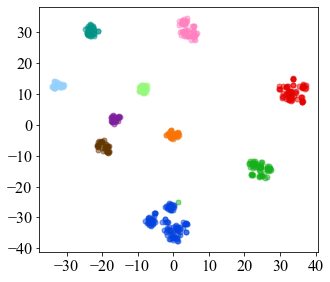

Variance Within-Class Between-Class
           0.0405     0.8459
The number of hard utterances:  63884
Skip vectors:  86990
PCA... dimension is reduced to  64


/home/yangwenhao/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:699: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning


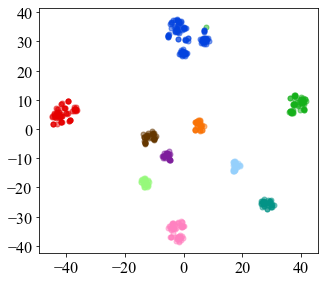

Variance Within-Class Between-Class
           0.0626     0.7882
The number of hard utterances:  63884
Skip vectors:  86990
PCA... dimension is reduced to  64


/home/yangwenhao/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:699: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning


Plot legend...


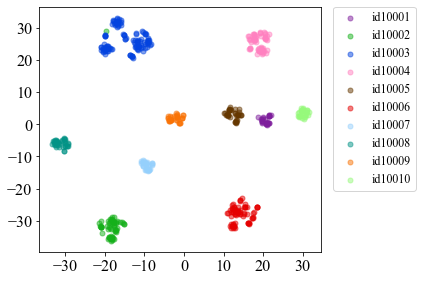

Variance Within-Class Between-Class
           0.0637     0.8341


In [120]:
for scp_file, pdf_file in zip(scp_files, pdf_files):
    vects = {}

    with open(scp_file, 'r') as f:
        for l in f.readlines():
            uid, upath = l.split()
            vects[uid] = load_mat(data_dir + '/' + upath)

    # with ReadHelper('scp:%s'% scp_file) as reader:
    #     for key, numpy_array in reader:
    #         vects[key] = numpy_array
    spks = set([])
    for key in vects:
        s = key[:sid_length]
        spks.add(s)

    spks = list(spks)
    spks.sort()
    
    hard_uids = set([])
    if os.path.exists(hard_vector):
        with open(hard_vector, 'r') as f:
            for uid in f.readlines():
                hard_uids.add(uid.rstrip('\n'))
        print('The number of hard utterances: ', len(hard_uids))
    else:
        print('There is no hard samples: ', hard_vector)

    spk2vec = {}
    for s in spks:
        spk2vec[s] = []

    # pdb.set_trace()
    skip = 0
    for key in vects:
        # if key[:args.sid_length] in spks_this:
        this_vec = vects[key]
        vec_len = len(this_vec)
        if (len(hard_uids) > 0 and key in hard_uids) or len(hard_uids) == 0:
            spk2vec[key[:sid_length]].append(this_vec.reshape(1, vec_len))
        else:
            skip += 1

    print('Skip vectors: ', skip)
    spks_this = []
    for spk in spks:
        if len(spk2vec[spk]) > 0:
            spks_this.append(spk)
            if len(spks_this) >= num_spk:
                break
    # spks_this = spks[:args.num_spk] if len(spks) > args.num_spk else spks
    all_vectors = []
    all_len = [0]

    if num_spk > 0:
        for spk in spks_this:
            if len(spk2vec[spk]) > 0:
                spk_con = np.concatenate(spk2vec[spk])
                all_len.append(len(spk_con))
                all_vectors.append(spk_con)

        all_vectors = np.concatenate(all_vectors, axis=0)

        if pca_dim > 0:
            print('PCA... dimension is reduced to ', pca_dim)
            pca = PCA(n_components=pca_dim)
            all_vectors = pca.fit_transform(all_vectors)

        S_embedded = TSNE(n_components=2, metric='cosine').fit_transform(all_vectors)
        emb_group = []
        for i in range(len(all_len) - 1):
            start = np.sum(all_len[:(i + 1)]).astype(np.int32)
            stop = np.sum(all_len[:(i + 2)]).astype(np.int32)
            this_points = S_embedded[start:stop]
            assert len(this_points) > 0, 'start:stop is %s:%s' % (start, stop)
            emb_group.append(this_points)

        plot_legend = True if 'manifold' in pdf_file else False
        fig_width = 6.5 if plot_legend else 5
        plt.figure(figsize=(fig_width, 4.5))
        font_manager = FontManager()
        font_manager.addfont(path='/home/yangwenhao/.fonts/TimesNewRoman.ttf')
        plt.rcParams['font.sans-serif'] = 'Times New Roman'

        # FontManager.addfont('/home/yangwenhao/font/TimesNewRoman.ttf')
        # plt.rcParams['font.sans-serif'] = 'Times New Roman'
        # font = FontProperties(fname='/home/yangwenhao/font/TimesNewRoman.ttf')
        # plt.rc('font', family='Times New Roman', weight='semibold')

        leng = []
        for idx, group in enumerate(emb_group):
            if len(group) > 0:
                c = cValue_1[idx]
                leng.append(spks_this[idx])
                plt.scatter(group[:, 0], group[:, 1], color=c, s=25, alpha=0.5)

        # plt.legend(leng, loc="best", fontsize=10, bbox_to_anchor=(1, 1.05), borderaxespad=1)  # , fontproperties=font)
        # plt.xlim([-20, 20])
        # plt.ylim([-20, 20])
        if plot_legend:
            print('Plot legend...')
            plt.legend(leng, loc="best", fontsize=12, bbox_to_anchor=(1, 1.05),
                       borderaxespad=1)  # , fontproperties=font)
            # plt.xlim([-20, 20])
            # plt.ylim([-20, 20])
            plt.subplots_adjust(right=4/5.5)

        # plt.xticks(fontsize=16, fontproperties=font)
        # plt.yticks(fontsize=16, fontproperties=font)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        if pdf_file.endswith('pdf'):
            plt.savefig(pdf_file, format="pdf")

        plt.show()

    if distance == 'l2':
        dist_fn = l2
    elif distance == 'cos':
        dist_fn = cos

    within_vars = []
    spk2num_utt = []
    for spk in spk2vec:
        if len(spk2vec[spk]) > 0:
            spk_mean = np.mean(spk2vec[spk], axis=0)
            within_var = 0
            for vec in spk2vec[spk]:
                within_var += dist_fn(vec, spk_mean) ** 2
            within_var /= len(spk2vec[spk])

            # within_var = np.var(spk2vec[spk], axis=0).sum()
            within_vars.append(within_var)
            spk2num_utt.append(len(spk2vec[spk]))

    within_var = np.array(within_vars) * np.array(spk2num_utt)
    within_var = np.sum(within_var) / np.sum(spk2num_utt)

    # between_var = np.var(all_vectors, axis=0).sum() - within_var
    all_vectors = []
    for spk in spk2vec:
        if len(spk2vec[spk]) > 0:
            spk_con = np.concatenate(spk2vec[spk])
            all_vectors.append(spk_con)
    all_vectors = np.concatenate(all_vectors, axis=0)

    overall_mean = np.mean(all_vectors, axis=0)
    between_var = 0
    for spk in spk2vec:
        if len(spk2vec[spk]) > 0:
        # between_var += np.sum((np.mean(spk2vec[spk], axis=0)-overall_mean)**2) * len(spk2vec[spk])
            between_var += dist_fn(np.mean(spk2vec[spk], axis=0), overall_mean) ** 2 * len(spk2vec[spk])

    between_var /= np.sum(spk2num_utt)

    print("Variance Within-Class Between-Class\n", '         {:>7.4f}    {:>7.4f}'.format(within_var, between_var))

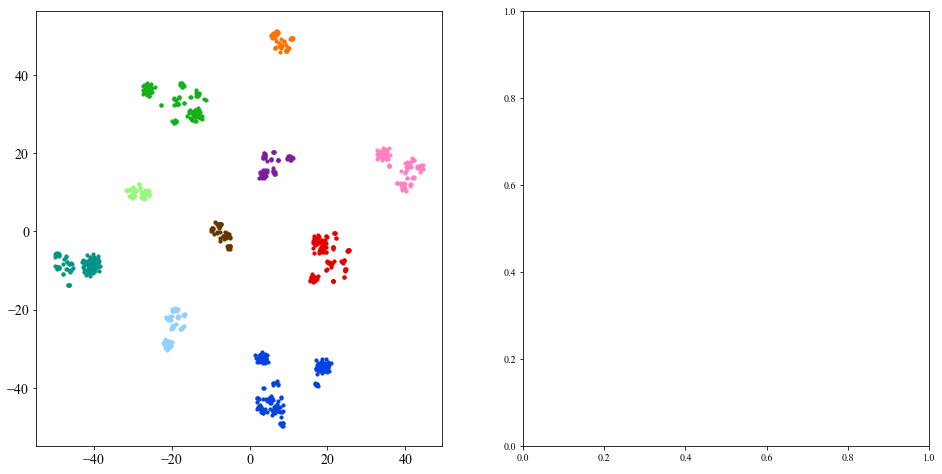

In [43]:
plt.figure(figsize=(16,8))
plt.rc('font', family='Times New Roman')

leng = []
plt.subplot(1,2,1)
for idx, group in enumerate(emb_group) :
    if len(group)>0:
        c = cValue_1[idx]
        leng.append(spks_this[idx])
        plt.scatter(group[:,0], group[:, 1], color=c, s=10)

# plt.legend(leng, loc="best", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(1,2,2)
within_vars = []
for spk in spk2vec:
    within_vars.append(np.var(spk2vec[spk], axis=0).sum())


plt.savefig("./tsne.pdf", format="pdf")
plt.show()

In [44]:
within_vars = []
spk2num_utt = []

dist_fn = cos
for spk in spk2vec:
    spk_mean = np.mean(spk2vec[spk], axis=0)
    within_var = 0
    for vec in spk2vec[spk]:
        within_var += dist_fn(vec, spk_mean)**2
    within_var /= len(spk2vec[spk])
    
    # within_var = np.var(spk2vec[spk], axis=0).sum()
    within_vars.append(within_var)
    spk2num_utt.append(len(spk2vec[spk]))

within_var = np.array(within_vars) * np.array(spk2num_utt)
within_var = np.sum(within_var) / np.sum(spk2num_utt)

# between_var = np.var(all_vectors, axis=0).sum() - within_var
overall_mean = np.mean(all_vectors, axis=0)
between_var = 0
for spk in spk2vec:
    # between_var += np.sum((np.mean(spk2vec[spk], axis=0)-overall_mean)**2) * len(spk2vec[spk])
    between_var += dist_fn(np.mean(spk2vec[spk], axis=0), overall_mean)**2 * len(spk2vec[spk])

between_var /= np.sum(spk2num_utt)

print("Variance Within-Class Between-Class\n", '         {:>7.4f}    {:>7.4f}'.format(within_var, between_var))
# print(within_var, between_var, np.var(all_vectors, axis=0).sum() - within_var)

# print(within_vars, np.array(spk2vec[spk]).shape, np.array(spk2vec[spk]).var(axis=0).shape)

# np.array(spk2vec[spk]).shape

# l2
# Variance Within-Class Between-Class
#            3.4290     3.6612

Variance Within-Class Between-Class
           0.0635     0.7853


In [ ]:
print(within_vars)
print(spk2num_utt)

In [46]:
# Within-Class Between-Class

# numofspk = 7
baseline = 20.0433/16.5956
input_mixup = 19.1580/12.4805
mani_mixup = 24.7667/16.4467
print(baseline, input_mixup, mani_mixup)


# numofspk = 40
baseline = 19.7768  /  26.2235
input_mixup = 18.9900  /  20.1494
mani_mixup = 24.4632  /  26.5282
print(baseline, input_mixup, mani_mixup)


# vox1_test numofspk = 20
baseline = 0.0870   /  0.6222
input_mixup = 0.1104  /   0.5906
mani_mixup = 0.1073  /   0.6121
print(baseline, input_mixup, mani_mixup)
      
# vox1_dev numofspk = 20
baseline = 0.0410   /  0.8528
input_mixup = 0.0635 /    0.7853
mani_mixup = 0.0646   /  0.8326
print(baseline, input_mixup, mani_mixup)

1.2077478367760128 1.5350346540603343 1.5058765588233507
0.7541632505195721 0.9424598251064547 0.922158307009145
0.1398264223722276 0.1869285472400948 0.17529815389642217
0.04807692307692308 0.08086081752196612 0.07758827768436224


In [47]:
a = np.random.rand(12)
b = np.random.rand(12)
print(cos(a, b), l2(a, b))

0.5046361072224945 1.4809278042662815


In [48]:
a = np.random.rand(12)